In [1]:
import gensim
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from nltk.tokenize import WordPunctTokenizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tqdm
from copy import deepcopy

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
DATA_PATH = '../data/raw/labeled_texts_fixed.csv'

In [4]:
df = pd.read_csv(DATA_PATH)

# Готовый word2vec

In [5]:
%%time
ru_emb = KeyedVectors.load_word2vec_format("../models/word2vec_embeddings/cc.ru.300.vec")

CPU times: total: 5min 13s
Wall time: 5min 58s


In [6]:
ru_emb.most_similar('славяне')

[('Славяне', 0.833034336566925),
 ('германцы', 0.7025650143623352),
 ('русичи', 0.702156126499176),
 ('финно-угры', 0.6992863416671753),
 ('славян', 0.6982200741767883),
 ('индоевропейцы', 0.6871833801269531),
 ('русы', 0.6846401691436768),
 ('славянские', 0.670945405960083),
 ('балты', 0.6670456528663635),
 ('скандинавы', 0.661027729511261)]

In [7]:
type(ru_emb.index_to_key)

list

# Самостоятельное обучение

In [8]:
texts = list(df['texts'])

In [9]:
tokenizer = WordPunctTokenizer()

In [10]:
data_tok = [tokenizer.tokenize(str(text).lower()) for text in texts]

In [38]:
train_tokens, test_tokens, y_train, y_test = train_test_split(data_tok, df['nationality'], test_size=0.2)

In [12]:
y_train.mean()

0.10377853581737077

In [13]:
len(test_tokens)

1906

In [14]:
%%time
model = Word2Vec(train_tokens, 
                 vector_size=300,      # embedding vector size
                 min_count=0,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

CPU times: total: 24.1 s
Wall time: 10.8 s


In [15]:
model

In [16]:
class Dictionaries():
        
        def __init__(self, tokens):
            self.count_tokens(tokens)

            self.idx_to_word = ['PADDING', 'UNK'] + list(ru_emb.index_to_key)
            self.word_to_idx = {key: i for i, key in enumerate(self.idx_to_word)}
            #self.idx_counter = [self.words_counter[word] for word in self.idx_to_word]
            self.amount_of_words = len(self.idx_to_word)
                
        def count_tokens(self, tokens):
            self.words_counter = Counter()
            self.amount_of_tokens = 0
            for s in tokens:
                self.words_counter.update(s)
                self.amount_of_tokens += len(s)
                

In [17]:
data_dicts = Dictionaries(train_tokens)
idx_to_word = data_dicts.idx_to_word
word_to_idx = data_dicts.word_to_idx
pad_idx = 0
unk_idx = 1

In [18]:
idx_to_word[337284]

'PAD'

In [19]:
a = [2, 4, 5]
a[2:4]

[5]

In [20]:
word_to_idx

{'PADDING': 0,
 'UNK': 1,
 ',': 2,
 '.': 3,
 'и': 4,
 'в': 5,
 '</s>': 6,
 ':': 7,
 ')': 8,
 '(': 9,
 'на': 10,
 '"': 11,
 'с': 12,
 'не': 13,
 '»': 14,
 'для': 15,
 '-': 16,
 '«': 17,
 '/': 18,
 'по': 19,
 '—': 20,
 'что': 21,
 'В': 22,
 '!': 23,
 'из': 24,
 'от': 25,
 'к': 26,
 'как': 27,
 '?': 28,
 'а': 29,
 '–': 30,
 'за': 31,
 ';': 32,
 'о': 33,
 'или': 34,
 'это': 35,
 '�': 36,
 '1': 37,
 '...': 38,
 '_': 39,
 "'": 40,
 'его': 41,
 'у': 42,
 'до': 43,
 '|': 44,
 '2': 45,
 'но': 46,
 'все': 47,
 'года': 48,
 '+': 49,
 'я': 50,
 'то': 51,
 '%': 52,
 'при': 53,
 'он': 54,
 'так': 55,
 'же': 56,
 'только': 57,
 '3': 58,
 'их': 59,
 'А': 60,
 'можно': 61,
 '#': 62,
 'был': 63,
 'И': 64,
 'время': 65,
 'также': 66,
 'году': 67,
 '10': 68,
 'было': 69,
 'будет': 70,
 'может': 71,
 'вы': 72,
 '0': 73,
 'уже': 74,
 '[': 75,
 ']': 76,
 '4': 77,
 '>': 78,
 'чтобы': 79,
 'есть': 80,
 'На': 81,
 'если': 82,
 '5': 83,
 '…': 84,
 'г': 85,
 'которые': 86,
 'С': 87,
 'без': 88,
 'со': 89,
 'очень

In [21]:
def index_tokens(tokens_string):
    return([word_to_idx.get(token, unk_idx) for token in tokens_string])

def fill_with_pads(tokens, pad_idx=0):
    max_len = 0
    for tokens_string in tokens:
        max_len = max(max_len, len(tokens_string))
    for tokens_string in tokens:
        for i in range(len(tokens_string), max_len):
            tokens_string.append(pad_idx)
    return tokens

def as_matrix(tokens):
    tokens = deepcopy(tokens)
    for j, s in enumerate(tokens):
        tokens[j] = index_tokens(s)
    tokens = fill_with_pads(tokens, pad_idx=pad_idx)
    return tokens

def vectorize_text(tokens):
    text_vector = np.zeros(300)
    c = 0
    for token in tokens:
        if idx_to_word[token] in ru_emb.key_to_index.keys():
            text_vector += ru_emb.get_vector(idx_to_word[token])
            c += 1
    return text_vector / 1

def batch_generator(tokens, labels, batch_size=16):
    for i in range(0, len(tokens), batch_size):
        batch_tokens = as_matrix(tokens[i: i + batch_size])
        batch_texts = np.zeros((len(batch_tokens), 300))
        for j in range(len(batch_tokens)):
            batch_texts[j] = vectorize_text(batch_tokens[j])
        batch_texts = torch.tensor(batch_texts, dtype=torch.float32)
        batch_labels = torch.tensor(labels.values[i: i + batch_size], dtype=torch.long)
        yield batch_texts, batch_labels
        
def get_train_batch(train_tkns, train_labels):
    train_tkns = as_matrix(train_tkns)
    train_texts = np.zeros((len(train_tkns), 300))
    for i in range(len(train_tkns)):
        train_texts[i] = vectorize_text(train_tkns[i])
    train_texts = torch.tensor(train_texts, dtype=torch.float32)
    train_labels = torch.tensor(train_labels.values, dtype=torch.long)
    return train_texts, train_labels       


def get_test_batch(test_tkns, test_labels):
    test_tkns = as_matrix(test_tkns)
    test_texts = np.zeros((len(test_tkns), 300))
    for i in range(len(test_tkns)):
        test_texts[i] = vectorize_text(test_tkns[i])
    test_texts = torch.tensor(test_texts, dtype=torch.float32)
    test_labels = torch.tensor(test_labels.values, dtype=torch.long)
    return test_texts, test_labels

In [40]:
test_batch = get_test_batch(test_tokens, y_test)
train_batch = get_train_batch(train_tokens, y_train)

In [23]:
test_batch

(tensor([[ 0.2989, -4.4533,  1.7129,  ...,  1.3623, -0.2431, -6.3785],
         [ 0.7883, -5.8524,  1.2781,  ...,  3.3171,  0.1793, -4.6619],
         [ 1.2134, -3.3050,  0.1915,  ...,  1.0320,  1.9319, -3.9604],
         ...,
         [ 0.6713, -1.4227, -0.5058,  ...,  1.3700,  1.1234, -0.7103],
         [ 0.7345, -5.3401, -1.0244,  ...,  0.5507, -0.9352, -8.7381],
         [ 0.2536, -0.4296,  0.6638,  ...,  0.7759,  0.3894, -0.7095]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [24]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(300, 2)
        )
    def forward(self, batch):
        out = self.linear(batch)
        return F.softmax(out)

In [25]:
nnet = LogReg()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters())

In [26]:
#test_tokens_as_matrix = as_matrix(test_tokens)

In [27]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [49]:
EPOCHS = 1000
BATCH_SIZE = 16
train_scores = []
test_scores = []
test_aucs = []

In [50]:
np.arange(0, 1)

array([0])

auc 0.9405418521525698
score 0.35897311568260193


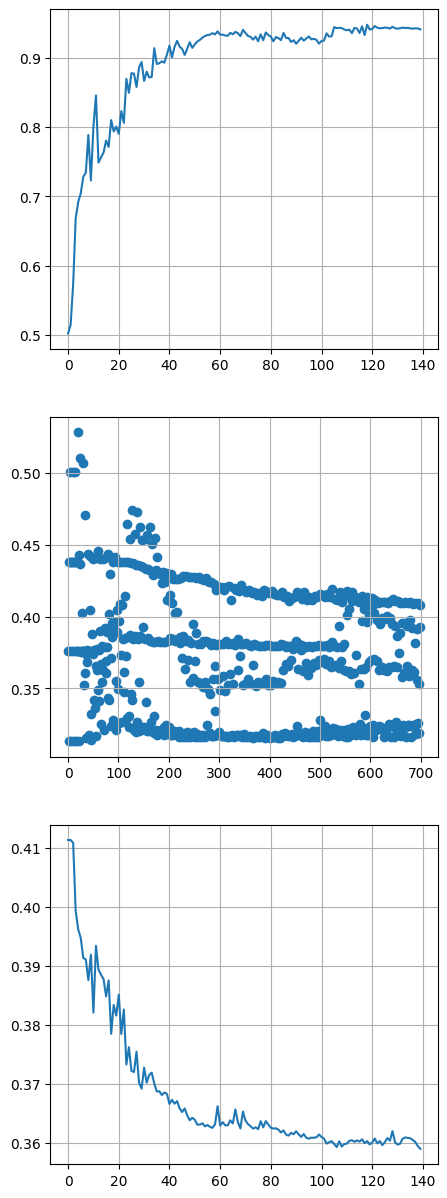

  0%|          | 0/476 [00:00<?, ?it/s]

C:\Users\andre\AppData\Local\Temp\ipykernel_4068\3832633500.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


0.32700520753860474
0.3253606855869293
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\andre\PycharmProjects\AdClassificationProject\venv\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\andre\AppData\Local\Temp\ipykernel_4068\4252432964.py", line 4, in <module>
    for i, batch in tqdm.notebook.tqdm(enumerate(batches), total=len(train_tokens) // BATCH_SIZE):
  File "C:\Users\andre\PycharmProjects\AdClassificationProject\venv\lib\site-packages\tqdm\notebook.py", line 259, in __iter__
    for obj in it:
  File "C:\Users\andre\PycharmProjects\AdClassificationProject\venv\lib\site-packages\tqdm\std.py", line 1195, in __iter__
    for obj in iterable:
  File "C:\Users\andre\AppData\Local\Temp\ipykernel_4068\3480005108.py", line 34, in batch_generator
    batch_texts[j] = vectorize_text(batch_tokens[j])
  File "C:\Users\andre\AppData\Local\Temp\ipykernel_4068\3480005108.py", line -1, in vectorize_text
KeyboardInterrupt

During h

In [51]:
for epoch in tqdm.notebook.tqdm(range(EPOCHS)):
    nnet.train()
    batches = batch_generator(train_tokens, y_train, batch_size=BATCH_SIZE)
    for i, batch in tqdm.notebook.tqdm(enumerate(batches), total=len(train_tokens) // BATCH_SIZE):
        nnet.train()
        pred = nnet(batch[0])
        loss = criterion(pred, batch[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            nnet.eval()
            train_score = criterion(nnet(batch[0]), batch[1])
            print(train_score.item())
            train_scores.append(train_score.item())
            nnet.train()
    nnet.eval()
    test_pred_prob = nnet(test_batch[0])
    test_score = criterion(test_pred_prob, test_batch[1])
    test_auc = roc_auc_score(test_batch[1], test_pred_prob.detach().numpy()[:, 1])
    test_scores.append(test_score.item())
    test_aucs.append(test_auc.item())
    nnet.train()
    clear_output(True)
    print('auc', test_auc.item())
    print('score', test_score.item())
    plt.figure(figsize=(5, 15))
    plt.subplot(3, 1, 1)
    plt.grid()
    plt.plot(np.arange(len(test_aucs)), test_aucs)
    plt.subplot(3, 1, 2)
    plt.grid()
    plt.scatter(np.arange(len(train_scores)), train_scores)
    plt.subplot(3, 1, 3)
    plt.plot(np.arange(len(test_scores)), test_scores)
    plt.grid()
    plt.show()

In [54]:
nnet(test_batch[0])[:, 0].max()

C:\Users\andre\AppData\Local\Temp\ipykernel_2224\3832633500.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


tensor(1., grad_fn=<MaxBackward1>)

In [61]:
for p in nnet.parameters():
    print(p.detach().numpy())

[[-1.45069551e+00 -6.02522969e-01  7.23327279e-01 -3.02553982e-01
   6.34652972e-02 -7.86499381e-01  2.64870614e-01  2.77743518e-01
  -7.14749873e-01  1.20733202e+00 -6.02412857e-02 -1.28348216e-01
  -9.93964449e-02  6.13177661e-04  3.64756770e-02 -4.66242909e-01
  -3.52481753e-01 -5.56635141e-01 -1.00631386e-01  1.82852596e-02
  -5.87712765e-01  3.48476321e-01  7.61805698e-02 -6.69802368e-01
   5.94499648e-01 -3.69937360e-01 -3.30360644e-02 -1.94146708e-01
  -1.20405686e+00 -8.79536331e-01 -6.96326733e-01 -6.03567883e-02
  -6.92950964e-01 -4.08714972e-02  4.71337922e-02  1.39598489e-01
   3.89686167e-01  1.44417584e-02 -3.66772652e-01 -4.93839057e-03
  -6.44536093e-02 -2.62015522e-01 -4.59018409e-01  3.83825481e-01
  -6.18142523e-02  3.28383923e-01  5.08964121e-01 -1.07802838e-01
   8.80100206e-02 -1.53523773e-01  1.50655165e-01  2.43172288e-01
  -4.51290518e-01 -3.97872120e-01  3.53930503e-01  5.66298485e-01
   3.55404973e-01  3.47692557e-02 -2.25745946e-01 -3.62478346e-01
   1.37317

In [62]:
nnet.parameters

<bound method Module.parameters of LogReg(
  (linear): Sequential(
    (0): Linear(in_features=300, out_features=2, bias=True)
  )
)>

In [105]:
np.random.rand()

0.15947985010702936

1363.7718505859375

In [112]:
len(word_to_idx)

26238

In [159]:
a = pd.Series([2, 4 ,6])

In [164]:
a[0:2]

0    2
1    4
dtype: int64

In [39]:
test_aucs

[0.5069428522072333,
 0.5086766022268636,
 0.509926661117829,
 0.5107370008009171,
 0.511415424721642]

# Sklearn logregression

In [65]:
from sklearn.linear_model import LogisticRegression

X_train_wv = train_batch[0]
X_test_wv = test_batch[0]

wv_model = LogisticRegression().fit(X_train_wv, y_train)

C:\Users\andre\PycharmProjects\AdClassificationProject\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [66]:
proba = wv_model.predict_proba(X_test_wv)[:, 1]
auc = roc_auc_score(y_test, proba)
auc

0.955321617779271

In [67]:
params

array([ 3.2212498, -3.1894004], dtype=float32)

In [68]:
wv_model.coef_

array([[ 0.6068846 ,  0.5311044 , -0.61434798,  0.09785686,  0.01941884,
         0.56744078, -0.10110315, -0.02423596,  0.26220809, -0.90891657,
         0.16890415,  0.26948325,  0.31147108,  0.07941169,  0.03911424,
         0.22184156,  0.30922842,  0.47337777,  0.10436283,  0.22613109,
         0.09921214, -0.24667616, -0.44108302,  0.31792649, -0.37745669,
         0.13246489, -0.07579596,  0.262548  ,  0.73045904,  0.83410242,
         0.38332079,  0.40174848,  0.04924922, -0.11627713, -0.04403685,
         0.07494581, -0.32433457,  0.17565442,  0.35215386,  0.24856219,
         0.01145145,  0.3688888 ,  0.04848042, -0.27855872,  0.08281587,
        -0.55799675, -0.36626966,  0.21761889, -0.08042622,  0.13266139,
        -0.15044371, -0.0641964 ,  0.2773314 ,  0.11437824, -0.04419563,
        -0.17529604, -0.09343046,  0.16761389,  0.67428333, -0.02353496,
        -0.53746912, -0.3032878 , -0.34120128,  0.20083248,  0.57155746,
        -0.30177597,  0.35481366, -0.01183518, -0.1